**Spring 2022 ATOC 4500 Final Project** 

**Devon Romero **

**Seasonal Variability Comparison between Southern New Mexico and Colorado**

**datasets:** 2_nm_data_2016-2021.csv AND hw4_mesa_data_2018-2021_withmissing.csv

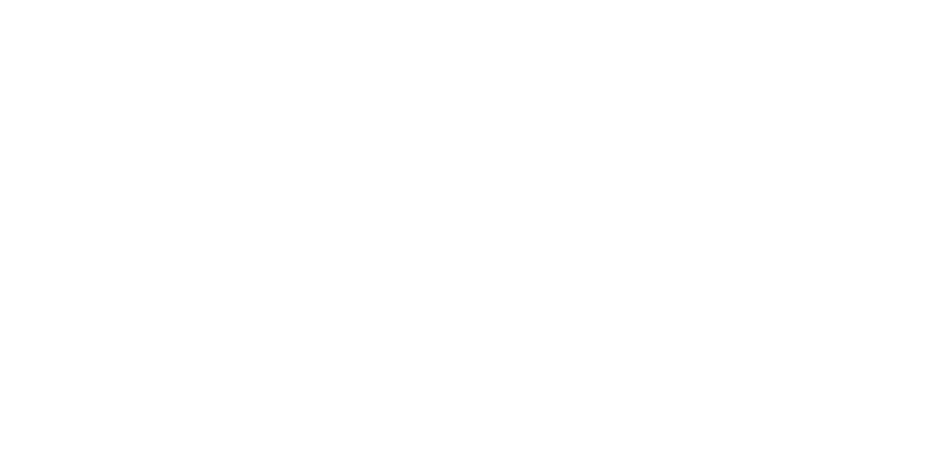

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import datetime
from google.colab import files

from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse
import pandas as pd 


**INTRODUCE DATASET 1**

This is 2018-2021 data from La Mesa, New Mexico. Variables in this data are 'Mean Air Temperature C', '3m Max Wind Speed m/s', '3m Wind Direction deg', 'Mean RH %', and 'Rain mm'. There was misisng data in the Wind Speed and Direction variables, we used the average to fill in these missing values. The data is in the file 2_nm_data_2018-2021.csv

In [ ]:
### upload file 2_nm_data_2018-2021.csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 2_nm_data_2018-2021.csv to 2_nm_data_2018-2021.csv
User uploaded file "2_nm_data_2018-2021.csv" with length 92525 bytes


In [ ]:
### Read in your data
### Use skiprows to read column header as first line 
df = pd.read_csv("2_nm_data_2018-2021.csv",skiprows=2)
#eliminate random misterious column:
df.drop(columns=['Unnamed: 12'],inplace=True)


#Rename rows to include units (elimanate separate rows for unit and variable names)
new_cols = [df.columns[1::][x] + ' ' + str(df.iloc[0][1::][x]) for x in range(len(df.columns)-1)]
new_cols.insert(0, 'Data')
new_cols

df.columns = new_cols
df = df.drop(df.index[0])

#we are creating this new data columns to help in the process of filling the gap
yy = []
mm = []
dd = []
for item in df['Data'][:]:
  item = item.split('-')
  yy.append(item[0])
  mm.append(item[1])
  dd.append(item[2])

#Add these columns to 
df.insert(1, 'Year',yy)
df.insert(2, 'Month', mm)
df.insert(3, 'Day', dd)

### Preview the values in the data frame by printing it
# print(df)
### Print the Shape of the data frame
print(df.shape)

(1461, 15)


In [ ]:
#check dataframe
df = df.astype({col: float for col in df.columns[4:]})
df 

Data  Year Month Day  Max Air Temperature C  \
1     2018-01-01  2018    01  01                    8.8   
2     2018-01-02  2018    01  02                   14.4   
3     2018-01-03  2018    01  03                   12.6   
4     2018-01-04  2018    01  04                   13.3   
5     2018-01-05  2018    01  05                   19.1   
...          ...   ...   ...  ..                    ...   
1457  2021-12-27  2021    12  27                   16.9   
1458  2021-12-28  2021    12  28                   15.0   
1459  2021-12-29  2021    12  29                   15.1   
1460  2021-12-30  2021    12  30                   13.4   
1461  2021-12-31  2021    12  31                    9.1   

      Min Air Temperature C  Mean Air Temperature C  Max RH %  Min RH %  \
1                      -3.4                     3.5      70.6      32.5   
2                      -5.3                     3.8      80.4      21.6   
3                      -7.8                     2.9      75.9      13.6   
4                      -2.8                     5.1      65.6      20.6   
5                      -5.4                     4.6      76.2      14.3   
...                     ...                     ...       ...       ...   
1457                   -3.1                     7.5      72.0      23.1   
1458                   -2.9                     6.3      93.4      19.6   
1459                   -4.1                     5.6      70.8      23.1   
1460                   -3.5                     5.7      85.1      37.6   
1461                    6.8                     7.9      98.2      68.8   

      Mean RH %  3m Max Wind Speed m/s  3m Mean Wind Speed m/s  \
1          48.6                   5.89                 1.44975   
2          47.2                    NaN                     NaN   
3          40.8                    NaN                     NaN   
4          38.6                    NaN                     NaN   
5          45.7                    NaN                     NaN   
...         ...                    ...                     ...   
1457       48.8                  12.40                 1.80000   
1458       53.2                   9.70                 1.80000   
1459       46.3                   8.50                 1.70000   
1460       62.5                   7.30                 1.20000   
1461       91.0                   7.60                 1.40000   

      3m Wind Direction deg  Rain mm  Solar Radiation MJ/m^2  
1                  203.8415    0.000                   11.28  
2                       NaN    0.000                   11.28  
3                       NaN    0.000                   10.33  
4                       NaN    0.000                    3.91  
5                       NaN    0.000                   10.96  
...                     ...      ...                     ...  
1457               159.8000    0.000                    5.69  
1458               199.5000    0.000                   13.37  
1459               211.3000    0.000                   13.72  
1460               158.4000    0.000                    8.31  
1461               123.8000   15.748                    1.89  

[1461 rows x 15 columns]

**Fill the Missing Data Using an Average**


In [ ]:
#fill mean wind data gap:
#first find indexes of locations with missing data
null_ind_max = df.index[df['3m Mean Wind Speed m/s'].isna()]
#3m mean wind
#loop around the indices with missing data and find corresponding days for other years to calculate mean and replace nan.
for i in null_ind_max:
  df['3m Mean Wind Speed m/s'].loc[i] = df[(df['Year'] != df['Year'].loc[i]) & (df['Month'] == df['Month'].loc[i]) & (df['Day'] == df['Day'].loc[i])]['3m Mean Wind Speed m/s'].mean()

In [ ]:
#fill max wind data gap:
#first find indexes of locations with missing data
null_ind_max = df.index[df['3m Max Wind Speed m/s'].isna()]
#3m max wind
#loop around the indices with missing data and find corresponding days for other years to calculate mean and replace nan.
for i in null_ind_max:
  df['3m Max Wind Speed m/s'].loc[i] = df[(df['Year'] != df['Year'].loc[i]) & (df['Month'] == df['Month'].loc[i]) & (df['Day'] == df['Day'].loc[i])]['3m Max Wind Speed m/s'].mean()

In [ ]:
#fill wind direction data gap:
#first find indexes of locations with missing data
null_ind_max = df.index[df['3m Wind Direction deg'].isna()]
#3m Wind Direction 
#loop around the indices with missing data and find corresponding days for other years to calculate mean and replace nan.
for i in null_ind_max:
  df['3m Wind Direction deg'].loc[i] = df[(df['Year'] != df['Year'].loc[i]) & (df['Month'] == df['Month'].loc[i]) & (df['Day'] == df['Day'].loc[i])]['3m Wind Direction deg'].mean()

In [ ]:
#check data for gaps (sanity check)
df

Data  Year Month Day  Max Air Temperature C  \
1     2018-01-01  2018    01  01                    8.8   
2     2018-01-02  2018    01  02                   14.4   
3     2018-01-03  2018    01  03                   12.6   
4     2018-01-04  2018    01  04                   13.3   
5     2018-01-05  2018    01  05                   19.1   
...          ...   ...   ...  ..                    ...   
1457  2021-12-27  2021    12  27                   16.9   
1458  2021-12-28  2021    12  28                   15.0   
1459  2021-12-29  2021    12  29                   15.1   
1460  2021-12-30  2021    12  30                   13.4   
1461  2021-12-31  2021    12  31                    9.1   

      Min Air Temperature C  Mean Air Temperature C  Max RH %  Min RH %  \
1                      -3.4                     3.5      70.6      32.5   
2                      -5.3                     3.8      80.4      21.6   
3                      -7.8                     2.9      75.9      13.6   
4                      -2.8                     5.1      65.6      20.6   
5                      -5.4                     4.6      76.2      14.3   
...                     ...                     ...       ...       ...   
1457                   -3.1                     7.5      72.0      23.1   
1458                   -2.9                     6.3      93.4      19.6   
1459                   -4.1                     5.6      70.8      23.1   
1460                   -3.5                     5.7      85.1      37.6   
1461                    6.8                     7.9      98.2      68.8   

      Mean RH %  3m Max Wind Speed m/s  3m Mean Wind Speed m/s  \
1          48.6               5.890000                1.449750   
2          47.2               7.166667                1.700000   
3          40.8               6.733333                1.533333   
4          38.6               4.900000                1.433333   
5          45.7               4.766667                1.133333   
...         ...                    ...                     ...   
1457       48.8              12.400000                1.800000   
1458       53.2               9.700000                1.800000   
1459       46.3               8.500000                1.700000   
1460       62.5               7.300000                1.200000   
1461       91.0               7.600000                1.400000   

      3m Wind Direction deg  Rain mm  Solar Radiation MJ/m^2  
1                203.841500    0.000                   11.28  
2                187.433333    0.000                   11.28  
3                206.433333    0.000                   10.33  
4                236.200000    0.000                    3.91  
5                185.300000    0.000                   10.96  
...                     ...      ...                     ...  
1457             159.800000    0.000                    5.69  
1458             199.500000    0.000                   13.37  
1459             211.300000    0.000                   13.72  
1460             158.400000    0.000                    8.31  
1461             123.800000   15.748                    1.89  

[1461 rows x 15 columns]

In [ ]:
### Check out the available days in this dataset
print(f'how many days are there in this dataset?')
#print(f'nyrs*ndays={4*365}') 
np.size(df['Data'])

how many days are there in this dataset?


1461

In [ ]:
selectdf = df[:]
print(len(selectdf))

1461


**Prepare Data to Plot**

In [ ]:
## Select variables of interest. Aside variables are called "features" by some in the ML world.
#YOU WILL NEED TO CHANGE VARIABLE NAMES BELOW TO NEW ONES (I only changed 2 of them in order to check it was working properly)
included_cols = ['Mean Air Temperature C','3m Max Wind Speed m/s','3m Wind Direction deg','Mean RH %','Rain mm',] 

## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
data = selectdf.loc[:, selectdf.columns.isin(list(included_cols))].to_numpy()

## check the shape of your data -- should be (4*365,6) (nyrs*ndays, variable) #CHECK # OF VARIABLES
print(f'Your data are now 1461 observations over 5 variables: {np.shape(data)}')
print(data.shape)

Your data are now 1461 observations over 5 variables: (1461, 5)
(1461, 5)


5
(1461, 5)
0


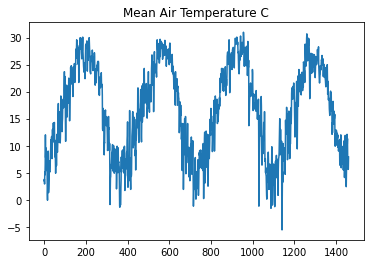

1


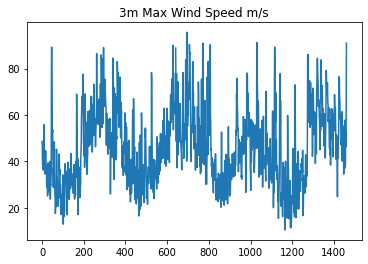

2


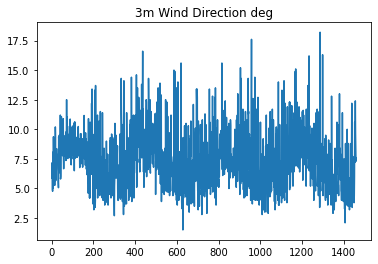

3


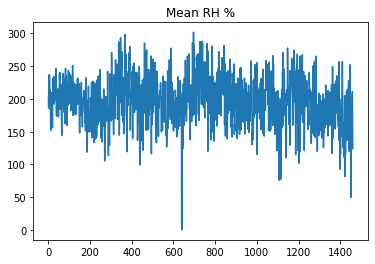

4


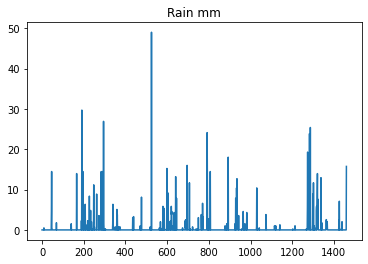

In [ ]:
#quickplot = 'yes'
#if quickplot == 'yes':
  ## Quick plots of your data
print(np.shape(data)[1])
print(data.shape)
for i in np.arange(0,np.shape(data)[1]):
    print(i)
    plt.plot(data[:,i]);
    plt.title(included_cols[i])
    plt.show()

**Apply Scientific Methods**

In [ ]:
seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4}

def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k]

df['season']=[season(month) for month in pd.DatetimeIndex(df['Data']).month]
(df.head)
#plt.plot(df['season'][:]);
#plt.show()

<bound method NDFrame.head of             Data  Year Month Day  Max Air Temperature C  \
1     2018-01-01  2018    01  01                    8.8   
2     2018-01-02  2018    01  02                   14.4   
3     2018-01-03  2018    01  03                   12.6   
4     2018-01-04  2018    01  04                   13.3   
5     2018-01-05  2018    01  05                   19.1   
...          ...   ...   ...  ..                    ...   
1457  2021-12-27  2021    12  27                   16.9   
1458  2021-12-28  2021    12  28                   15.0   
1459  2021-12-29  2021    12  29                   15.1   
1460  2021-12-30  2021    12  30                   13.4   
1461  2021-12-31  2021    12  31                    9.1   

      Min Air Temperature C  Mean Air Temperature C  Max RH %  Min RH %  \
1                      -3.4                     3.5      70.6      32.5   
2                      -5.3                     3.8      80.4      21.6   
3                      -7.8         

**Get Unit Variance by Scaling Data**

In [ ]:
##convert to numpy

included_cols = ['Mean Air Temperature C','3m Max Wind Speed m/s','3m Wind Direction deg','Mean RH %','Rain mm']
#included_cols = ['Mean Air Temperature C','Mean RH %']


## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
data = selectdf.loc[:, selectdf.columns.isin(list(included_cols))].to_numpy()

## check the shape of your data 
print(f'Your data are now 1461 observations over 5 variables: {np.shape(data)}')
print(data.shape)

#df.np=df.to_numpy
data[:,0]=np.where(np.isnan(data[:,0])==True,np.nanmean(data[:,0]),data[:,0])
data[:,1]=np.where(np.isnan(data[:,1])==True,np.nanmean(data[:,1]),data[:,1])
#data[:,2]=np.where(np.isnan(data[:,2])==True,np.nanmean(data[:,2]),data[:,2])
#data[:,3]=np.where(np.isnan(data[:,3])==True,np.nanmean(data[:,3]),data[:,3])
#data[:,4]=np.where(np.isnan(data[:,4])==True,np.nanmean(data[:,4]),data[:,4])
#data[:,5]=np.where(np.isnan(data[:,5])==True,np.nanmean(data[:,5]),data[:,5])

Your data are now 1461 observations over 5 variables: (1461, 5)
(1461, 5)


mean of each variable
standard deviation of each variable


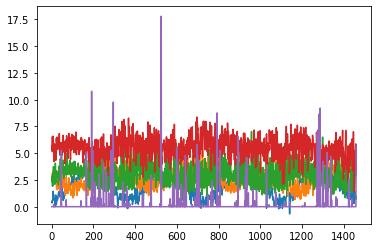

In [ ]:
scaled_data = whiten(data) 

print('mean of each variable')
#print(np.mean(scaled_data,axis=0))
print('standard deviation of each variable')
#print(np.std(scaled_data,axis=0))

plt.plot(scaled_data)

**Set Up Clustering**

In [ ]:
## select the number of clusters (i.e., here the number of seasons you want to try to identify using the weather data)
NO_CLUSTERS = 4 # use 4 clusters - see if you get out 4 seasons of winter, fall, spring, summer

centroids, _  = kmeans(scaled_data,NO_CLUSTERS,iter=20)

In [ ]:
idx, _ = vq(scaled_data,centroids) # vq returns cluster idx for each observation

## add 1 so that idx is also 1-based like df['season']
idx=idx+1

print('Here is the cluster idx for each day of the year:') 
print(idx.shape) # prints K-mean's season label for each day

print(np.min(idx))
print(np.max(idx))

print(idx)

Here is the cluster idx for each day of the year:
(1461,)
1
4
[4 4 4 ... 4 4 4]


1      2018-01-01
2      2018-01-02
3      2018-01-03
4      2018-01-04
5      2018-01-05
          ...    
1457   2021-12-27
1458   2021-12-28
1459   2021-12-29
1460   2021-12-30
1461   2021-12-31
Name: Data, Length: 1461, dtype: datetime64[ns]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 1

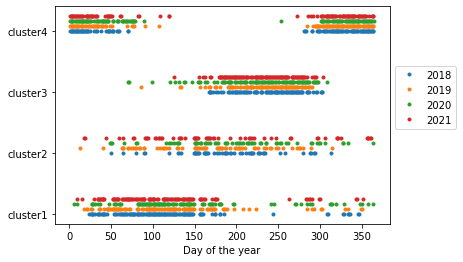

In [ ]:
## make the file date into a readable datetime
selectdf['Data']
print(pd.to_datetime(selectdf['Data'], format='%Y-%m-%dT%H:%M:%S'))

selectdf['datetime'] = pd.to_datetime(selectdf['Data'], format='%Y-%m-%dT%H:%M:%S')
selectdf

### find the julian day and year for each point in the dataset
import datetime as dt
fool=selectdf['datetime'].values

### sanity check code
#print(fool[0])
#dt.datetime.strptime('2018-01-01T00:00:00', '%Y-%m-%dT%H:%M:%S').strftime('%j')
#dt.datetime.strptime('2018-01-01T00:00:00.000000000', '%Y-%m-%dT%H:%M:%S.000000000').strftime('%j')
#dt.datetime.strptime(str(fool[0]), '%Y-%m-%dT%H:%M:%S.000000000').strftime('%j')

jday = [int(dt.datetime.strptime(str(date), '%Y-%m-%dT%H:%M:%S.000000000').strftime('%j')) for date in fool]
print(jday)
year = [int(dt.datetime.strptime(str(date), '%Y-%m-%dT%H:%M:%S.000000000').strftime('%Y')) for date in fool]
print(year)

### find the minimum and maximum index of the array for each year
idx_min=[]
idx_max=[]
for yearSEL in np.arange(2018,2022,1):
  #print(yearSEL)
  yearidx=[index for index,value in enumerate(year) if value==yearSEL]
  idx_min.append(min(yearidx))
  idx_max.append(max(yearidx))

### plot all years
for y in np.arange(0,4,1):
  plt.plot(jday[np.min(idx_min[y]):np.max(idx_max[y])],idx[np.min(idx_min[y]):np.max(idx_max[y])]+0.08*y,'.',label=str(y+2018));

plt.xlabel('Day of the year');
plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left', ncol=1);
plt.yticks(np.arange(1,NO_CLUSTERS+1),labels=['cluster1','cluster2','cluster3','cluster4']);

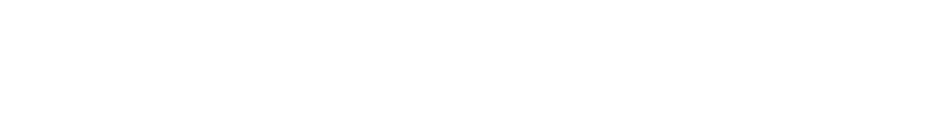

The code is the same as above, just without the rain variable and less number of clusters.

NEW MEXICO W/3 CLUSTERS NO RAIN

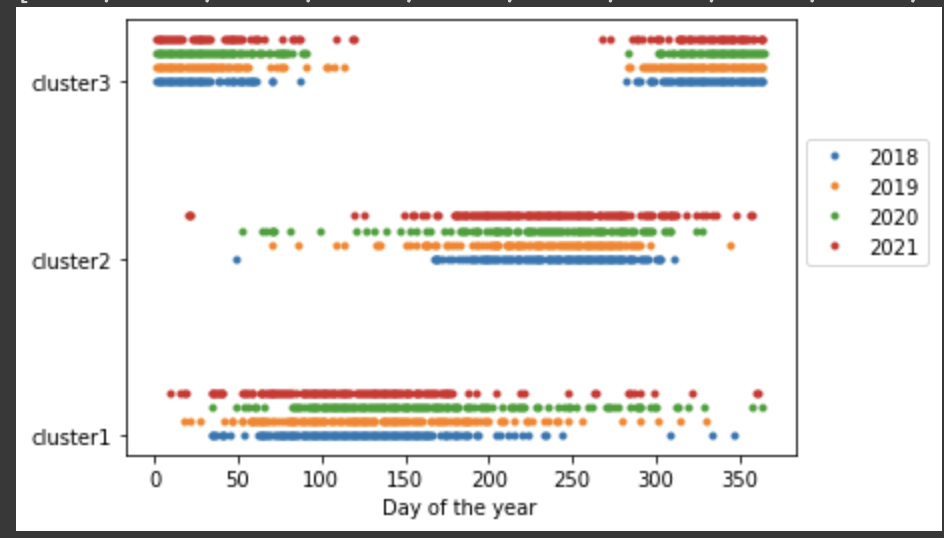

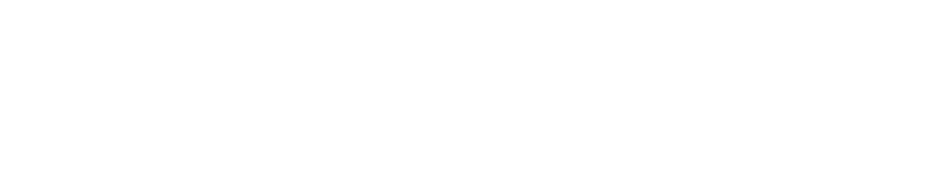

NEW MEXICO W/2 CLUSTERS NO RAIN

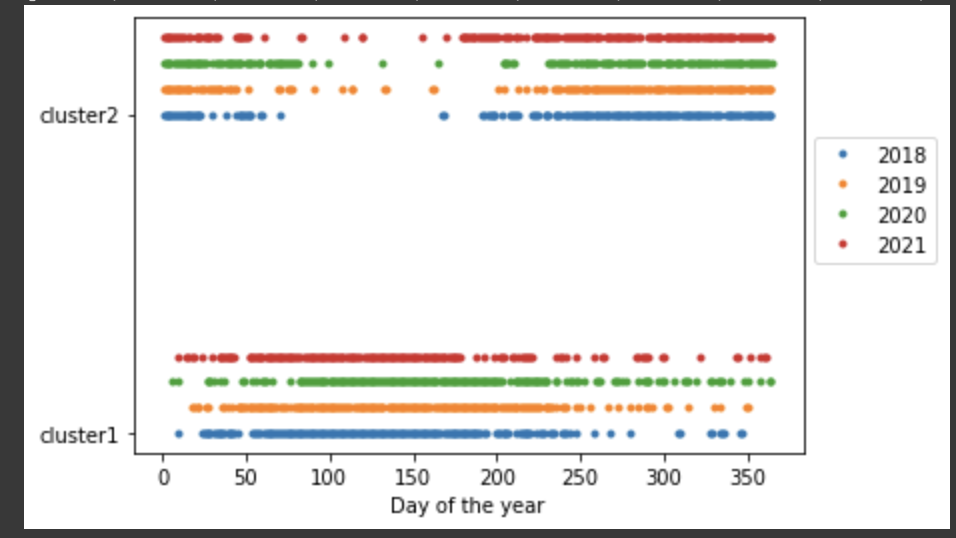

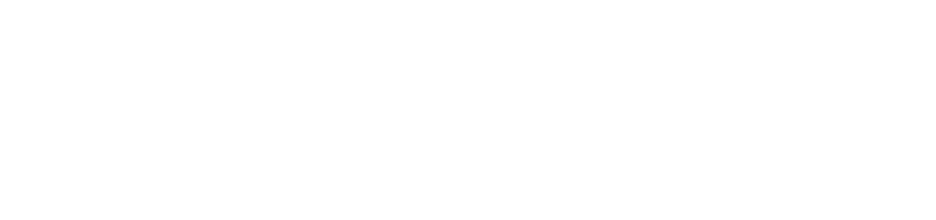

**Make 5 plots with Mean Air Temperature C and Other Variables** 

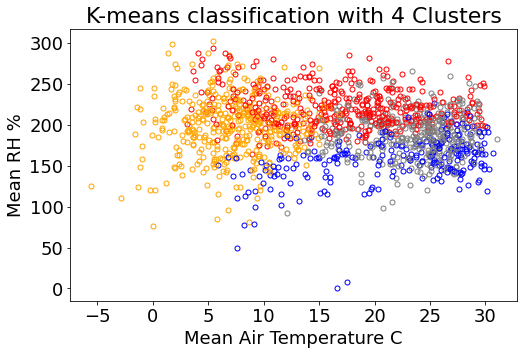

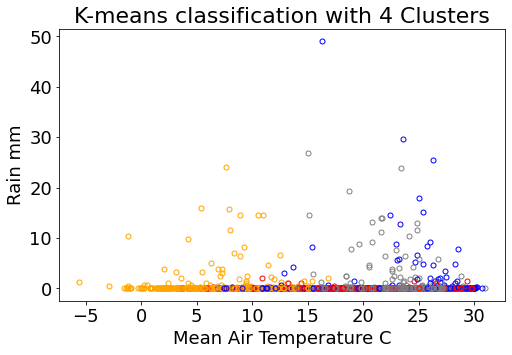

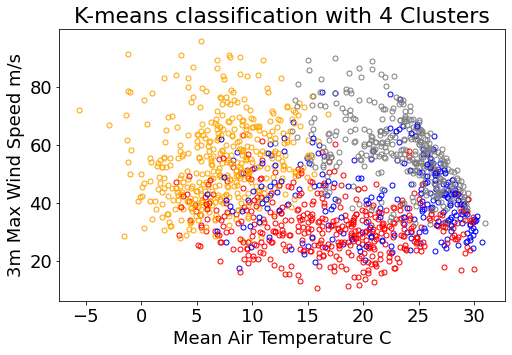

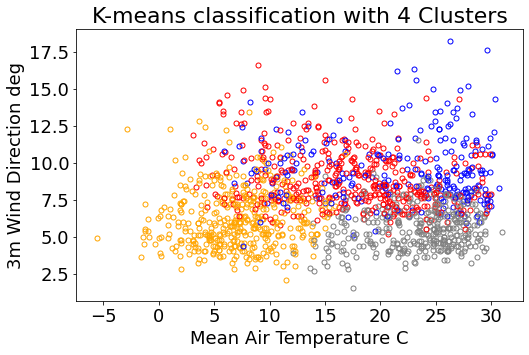

In [ ]:
## Create a few xy scatter plots, where points are colored by "season" (from clustering algorithm).

### Pick any two variables that are a part of included_cols
### ['Mean Air Temperature C','3m Max Wind Speed m/s','3m Wind Direction deg','Mean RH %','Rain mm','Solar Radiation MJ/m^2'] 
##print(included_cols)

##### PLOT #1

### select two variables and put them in vars1plot - # format (x, y)
vars1plot = ['Mean Air Temperature C','Mean RH %']
#print(f'plotting these variables: {vars1plot}')

data1plot = [data[:,included_cols.index(var)] for var in vars1plot]

## find the integer index of the variable to plot
varidx1plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  #print(vars2plot[i])
  varidx1plot[i]=included_cols.index(vars1plot[i])
#print(varidx2plot)

### Next plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data1plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars1plot[0],fontsize=18);
plt.ylabel(vars1plot[1],fontsize=18);
plt.show()

#plt.show()

##### PLOT #2

### select two variables and put them in vars2plot - # format (x, y)
vars2plot = ['Mean Air Temperature C','Rain mm']
#print(f'plotting these variables: {vars2plot}')

data2plot = [data[:,included_cols.index(var)] for var in vars2plot]

## find the integer index of the variable to plot
varidx2plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  varidx2plot[i]=included_cols.index(vars2plot[i])

### Now plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data2plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars2plot[0],fontsize=18);
plt.ylabel(vars2plot[1],fontsize=18);


##### PLOT #3
### select two variables and put them in vars3plot - # format (x, y)
vars3plot = ['Mean Air Temperature C','3m Max Wind Speed m/s']
#print(f'plotting these variables: {vars3plot}')

data3plot = [data[:,included_cols.index(var)] for var in vars3plot]

## find the integer index of the variable to plot
varidx3plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  varidx3plot[i]=included_cols.index(vars3plot[i])

### Now plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data3plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars3plot[0],fontsize=18);
plt.ylabel(vars3plot[1],fontsize=18);

##### PLOT #4

### select two variables and put them in vars4plot - # format (x, y)
vars4plot = ['Mean Air Temperature C','3m Wind Direction deg']
#print(f'plotting these variables: {vars4plot}')

data4plot = [data[:,included_cols.index(var)] for var in vars4plot]

## find the integer index of the variable to plot
varidx4plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  varidx4plot[i]=included_cols.index(vars4plot[i])

### Now plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data4plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars4plot[0],fontsize=18);
plt.ylabel(vars4plot[1],fontsize=18);

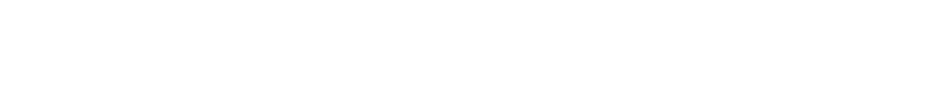

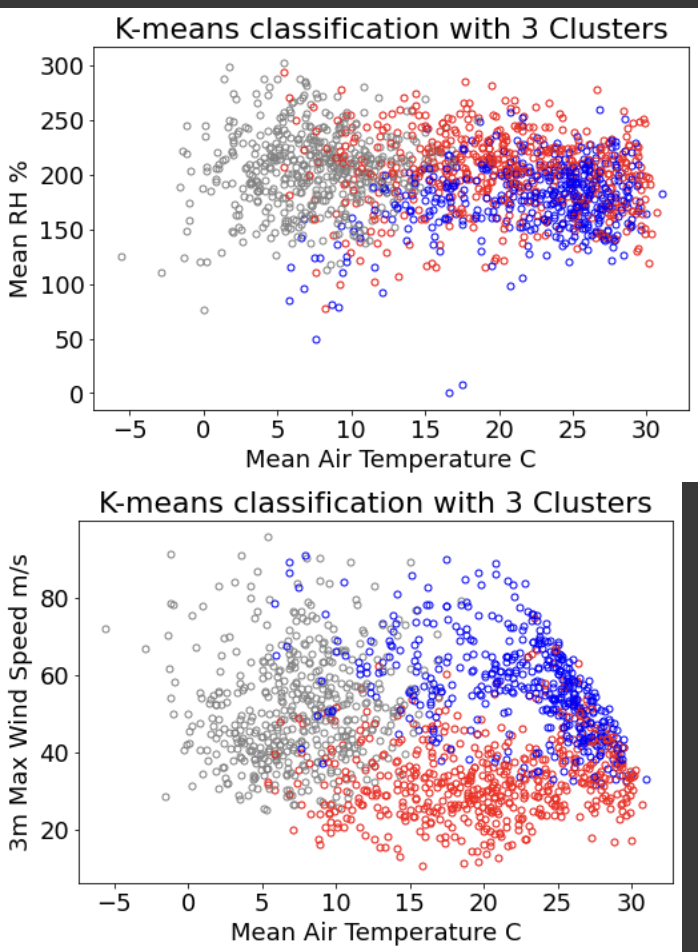

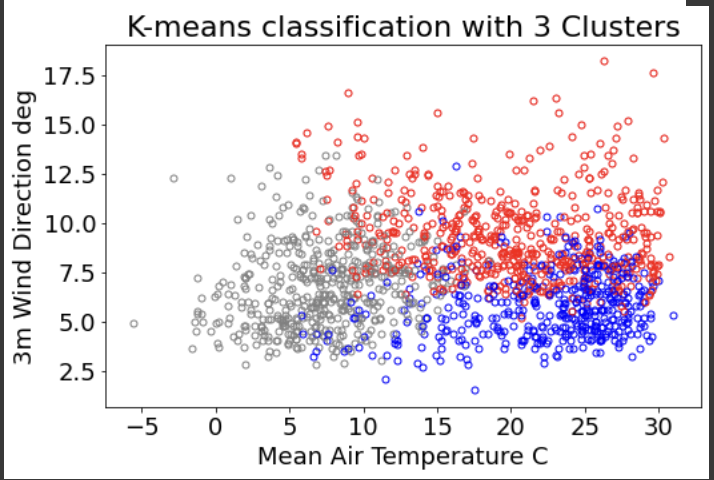

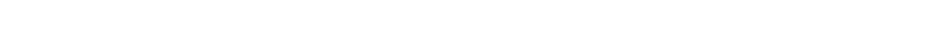

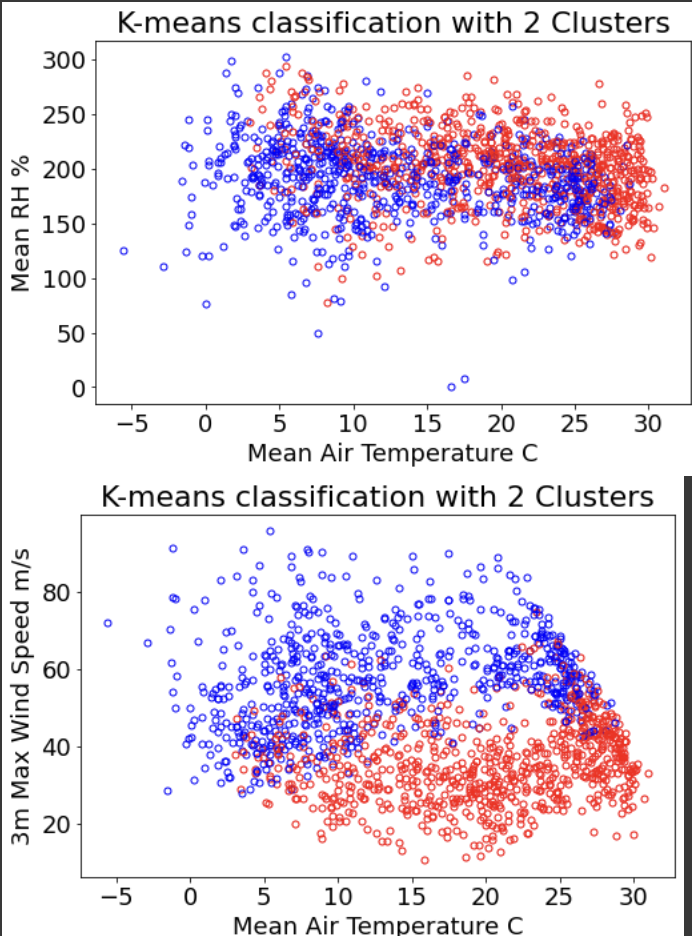

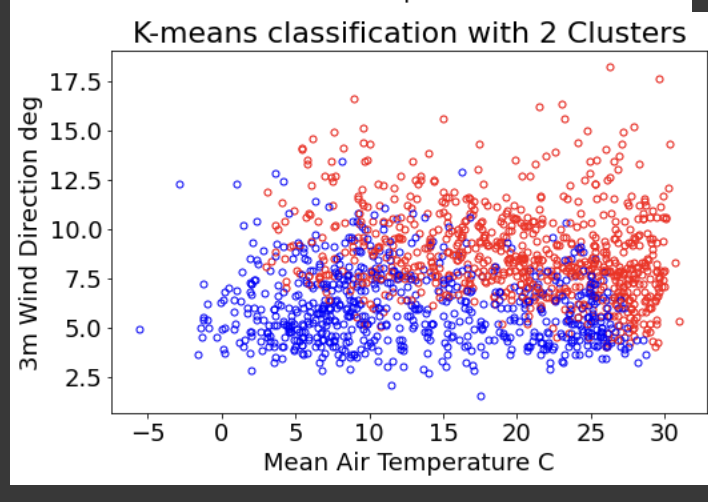

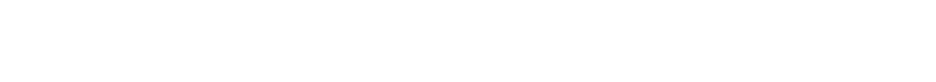

**Make Histogram for Final Analysis**


In [ ]:
#### prepare data to plot in the histograms

## this is the actual season from the definition in the season dictionary above
season_idx=df['season'].to_numpy()
print(season_idx.shape)

## this is the season from the k-means clustering algorithm
print(idx.shape)

### find what the k-means clustering assigned in each season

## find all of the days in winter, i.e., where season_idx=1
winteridx=np.nonzero(np.where(season_idx==1,1,0))
#print(winteridx) ### uncomment me to check the code
## find what values the k-means classified for this season
winter=idx[winteridx]
#print(winter)  ### uncomment me to check the code

## find all of the days in spring, i.e., where season_idx=2
springidx=np.nonzero(np.where(season_idx==2,1,0))
## find what values the k-means classified for this season
spring=idx[springidx]

## find all of the days in summer, i.e., where season_idx=3
summeridx=np.nonzero(np.where(season_idx==3,1,0))
## find what values the k-means classified for this season
summer=idx[summeridx]

## find all of the days in fall, i.e., where season_idx=4
fallidx=np.nonzero(np.where(season_idx==4,1,0))
## find what values the k-means classified for this season
fall=idx[fallidx]

(1461,)
(1461,)


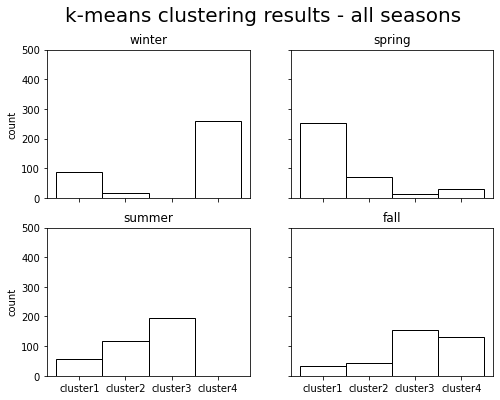

In [ ]:
### Histogram #1 - Histograms of seasons based on k-means clustering for each season

## define bins for the histogram
delta= 1                               ## bin size
minbin= 0.5                             ## minimum bin value
maxbin= 5.5                              ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
#print(hist_bins) ## print your histograms to check them

## sanity check = plot the histogram of assigned clusters for winter
#h, mids = np.histogram(winter,bins=hist_bins);
#labels4xaxis=['cluster1','cluster2','cluster3','cluster4']
#plt.figure(figsize=(4,4))
#plt.hist(winter,bins=mids,facecolor='w',edgecolor="k");
#plt.xticks(np.arange(1,4+1),labels=labels4xaxis);
#plt.title('Winter');
#plt.show();

### Show all seasons using subplots
### Help with subplots: https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

labels4xaxis=['','cluster1','cluster2','cluster3','cluster4']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('k-means clustering results - all seasons',fontsize=20)
fig.set_figheight(6)
fig.set_figwidth(8)

ymax=500
h, mids = np.histogram(winter,bins=hist_bins);
ax1.hist(winter,bins=mids,facecolor='w',edgecolor="k");
ax1.set_title("winter");
ax1.set_ylabel("count");
ax1.set_ylim(0,ymax)
h, mids = np.histogram(spring,bins=hist_bins);
ax2.hist(spring,bins=mids,facecolor='w',edgecolor="k");
ax2.set_title("spring");
ax2.set_ylim(0,ymax)
h, mids = np.histogram(summer,bins=hist_bins);
ax3.hist(summer,bins=mids,facecolor='w',edgecolor="k");
ax3.set_title("summer");
ax3.set_xticklabels(labels4xaxis);
ax3.set_ylabel("count");
ax3.set_ylim(0,ymax)
h, mids = np.histogram(fall,bins=hist_bins);
ax4.hist(fall,bins=mids,facecolor='w',edgecolor="k");
ax4.set_title("fall");
ax4.set_xticklabels(labels4xaxis);
ax4.set_ylim(0,ymax)

for ax in fig.get_axes():
    ax.label_outer()

The code is the same as above, just without the rain variable and less number of clusters.

NEW MEXICO W/3 CLUSTERS NO RAIN

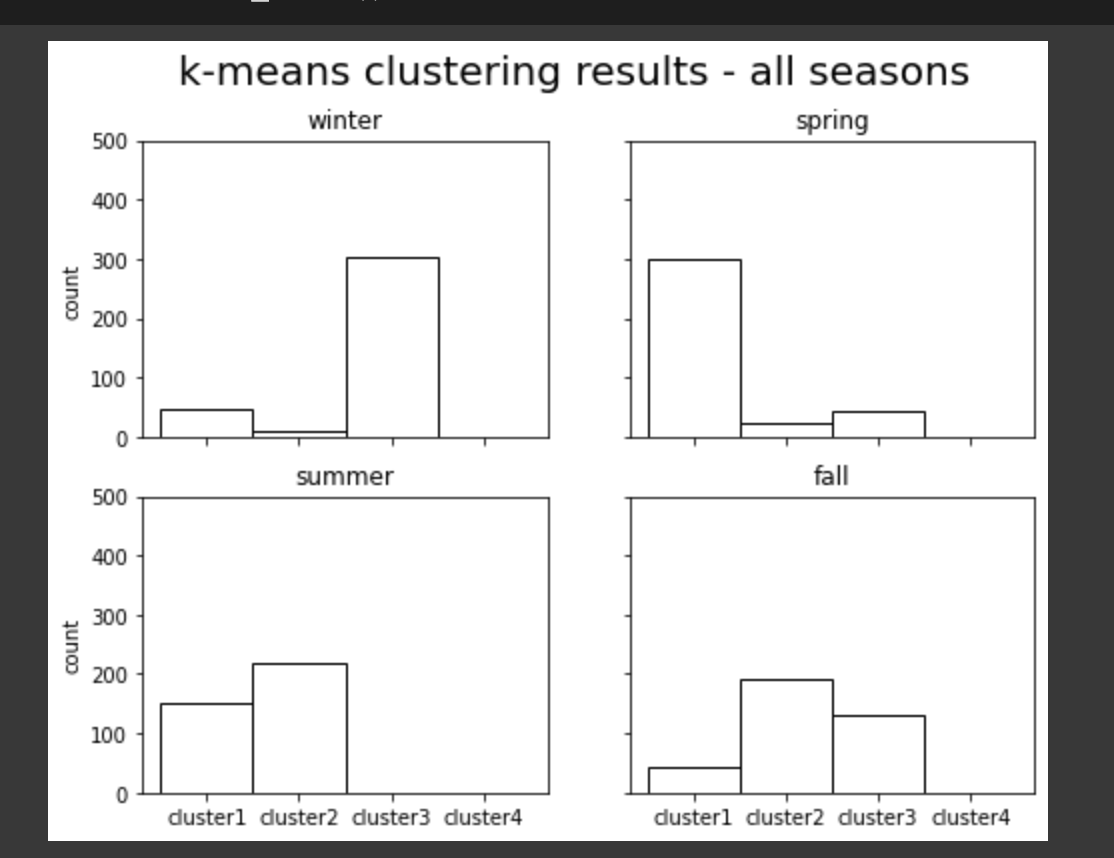

NEW MEXICO W/2 CLUSTERS NO RAIN

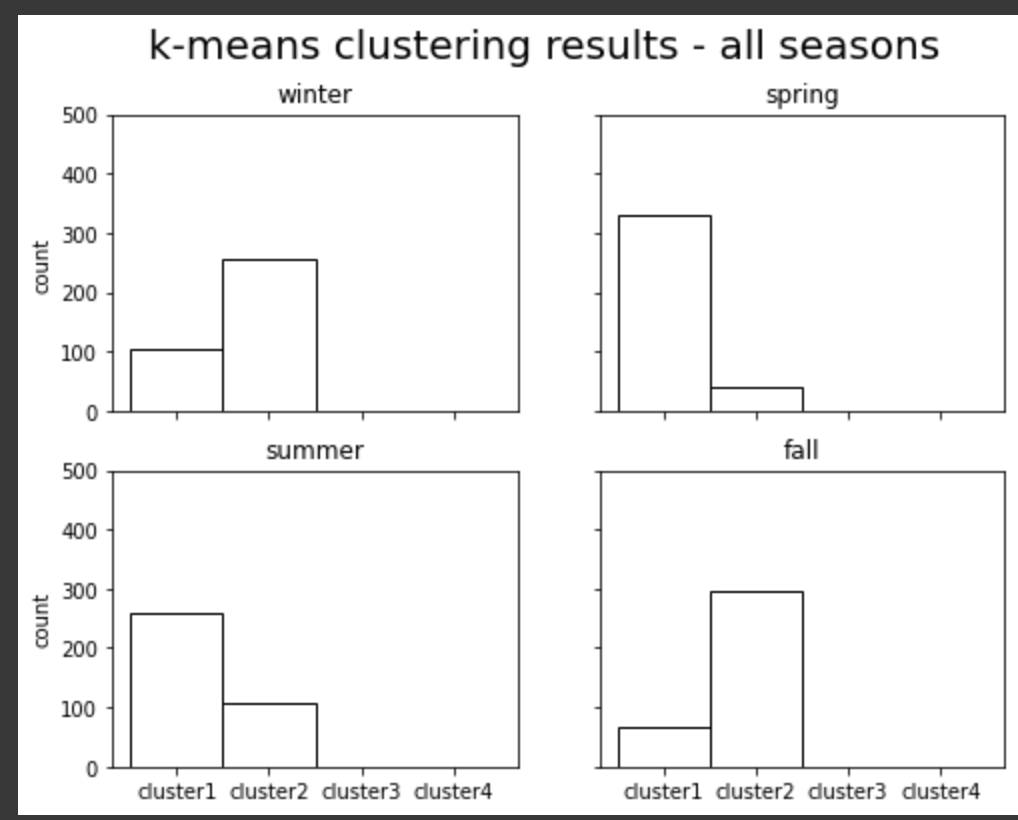

**INTRODUCE DATASET 2**

This data is the 2018-2021 weather data from the NCAR Mesa Laboratory in Boulder, Colorado. The dataset is called hw4_mesa_data_2018-2021_withmissing.csv. The variables used in this dataset are wspd_m_per_s', 'raina_event_mm', 'tdry_degC', 'rh_percent', and 'wdir'. The dataset originally included years 2016-2017 but those were removed for the purpose of this analysis. 

In [ ]:
### upload file hw4_mesa_data_2016-2021_withmissing.csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))#

Saving hw4_mesa_data_2016-2021_withmissing.csv to hw4_mesa_data_2016-2021_withmissing.csv
User uploaded file "hw4_mesa_data_2016-2021_withmissing.csv" with length 3355169 bytes


In [ ]:
### Read in your data_2
df_2 = pd.read_csv("hw4_mesa_data_2016-2021_withmissing.csv")

yy = []
mm = []
dd = []
for item in df_2['day'][:]:
  item = item.split('-')
  mm.append(item[1])
  dd.append(item[2])

#Add these columns to 
df_2.insert(2, 'Month', mm)
df_2.insert(3, 'Day', dd)


### Preview the values in the data frame by printing it
print(df_2)
### Print the Shape of the data frame
print(df_2.shape)


              day  hour_UTC Month Day     pres_mb  tdry_degC  rh_percent  \
0      2018-01-01       0.0    01  01  815.500000      -11.1   83.400002   
1      2018-01-01       1.0    01  01  815.799988      -11.1   83.800003   
2      2018-01-01       2.0    01  01  816.000000      -10.5   84.599998   
3      2018-01-01       3.0    01  01  815.900024      -11.3   82.699997   
4      2018-01-01       4.0    01  01  816.099976      -11.5   83.000000   
...           ...       ...   ...  ..         ...        ...         ...   
35035  2021-12-31      19.0    12  31  794.200012       -2.3   77.500000   
35036  2021-12-31      20.0    12  31  793.599976       -2.6   77.500000   
35037  2021-12-31      21.0    12  31  793.500000       -2.9   78.199997   
35038  2021-12-31      22.0    12  31  793.799988       -2.9   84.900002   
35039  2021-12-31      23.0    12  31  794.500000       -4.3   86.199997   

        wdir  wspd_m_per_s  wspdmax_m_per_s  raina_event_mm  year  
0      140.0       

In [ ]:
selectdf_2 = df_2[df_2.hour_UTC==4] ## noon
print(len(selectdf_2))
selectdf_2

1460


day  hour_UTC Month Day     pres_mb  tdry_degC  rh_percent  \
4      2018-01-01       4.0    01  01  816.099976      -11.5   83.000000   
28     2018-01-02       4.0    01  02  813.400024       -6.8   74.300003   
52     2018-01-03       4.0    01  03  816.700012        1.6   17.700001   
76     2018-01-04       4.0    01  04  812.500000        2.7   31.799999   
100    2018-01-05       4.0    01  05  813.599976        3.8   29.000000   
...           ...       ...   ...  ..         ...        ...         ...   
34924  2021-12-27       4.0    12  27  799.299988        0.5   42.500000   
34948  2021-12-28       4.0    12  28  790.700012        0.9   37.099998   
34972  2021-12-29       4.0    12  29  795.000000       -5.5   37.200001   
34996  2021-12-30       4.0    12  30  798.400024       -6.0   43.599998   
35020  2021-12-31       4.0    12  31  792.000000        3.8   32.000000   

        wdir  wspd_m_per_s  wspdmax_m_per_s  raina_event_mm  year  
4        6.0           1.2              2.0             0.0  2018  
28     315.0           1.8              2.8             0.0  2018  
52     319.0           1.1              2.3             0.0  2018  
76     310.0           2.5              3.7             0.0  2018  
100    234.0           1.0              2.4             0.0  2018  
...      ...           ...              ...             ...   ...  
34924  258.0           3.9              6.6             0.0  2021  
34948  140.0           1.2              1.9             0.0  2021  
34972  325.0           2.5              4.4             0.0  2021  
34996  317.0           1.7              2.8             0.0  2021  
35020  230.0          11.3             20.9             0.0  2021  

[1460 rows x 12 columns]

In [ ]:
##change to daily data not hourly
selectdf_3 = selectdf_2[df_2.year>2017] ## only after 2017
print(len(selectdf_3))
selectdf_3

1460


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


day  hour_UTC Month Day     pres_mb  tdry_degC  rh_percent  \
4      2018-01-01       4.0    01  01  816.099976      -11.5   83.000000   
28     2018-01-02       4.0    01  02  813.400024       -6.8   74.300003   
52     2018-01-03       4.0    01  03  816.700012        1.6   17.700001   
76     2018-01-04       4.0    01  04  812.500000        2.7   31.799999   
100    2018-01-05       4.0    01  05  813.599976        3.8   29.000000   
...           ...       ...   ...  ..         ...        ...         ...   
34924  2021-12-27       4.0    12  27  799.299988        0.5   42.500000   
34948  2021-12-28       4.0    12  28  790.700012        0.9   37.099998   
34972  2021-12-29       4.0    12  29  795.000000       -5.5   37.200001   
34996  2021-12-30       4.0    12  30  798.400024       -6.0   43.599998   
35020  2021-12-31       4.0    12  31  792.000000        3.8   32.000000   

        wdir  wspd_m_per_s  wspdmax_m_per_s  raina_event_mm  year  
4        6.0           1.2              2.0             0.0  2018  
28     315.0           1.8              2.8             0.0  2018  
52     319.0           1.1              2.3             0.0  2018  
76     310.0           2.5              3.7             0.0  2018  
100    234.0           1.0              2.4             0.0  2018  
...      ...           ...              ...             ...   ...  
34924  258.0           3.9              6.6             0.0  2021  
34948  140.0           1.2              1.9             0.0  2021  
34972  325.0           2.5              4.4             0.0  2021  
34996  317.0           1.7              2.8             0.0  2021  
35020  230.0          11.3             20.9             0.0  2021  

[1460 rows x 12 columns]

In [ ]:
print(f'how many days are there in this dataset?')
selectdf_3 = selectdf_3[:]
print(len(selectdf_3))

how many days are there in this dataset?
1460


In [ ]:
## Select variables of interest. Aside variables are called "features" by some in the ML world.
#YOU WILL NEED TO CHANGE VARIABLE NAMES BELOW TO NEW ONES (I only changed 2 of them in order to check it was working properly)
included_cols = ['wspd_m_per_s','raina_event_mm','tdry_degC','rh_percent','wdir'] 

## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
data_2 = selectdf_3.loc[:, selectdf_3.columns.isin(list(included_cols))].to_numpy()

## check the shape of your data -- should be (4*365,5) (nyrs*ndays, variable) #CHECK # OF VARIABLES
print(f'Your data are now 1461 observations over 5 variables: {np.shape(data_2)}')
print(data_2.shape)

Your data are now 1461 observations over 5 variables: (1460, 5)
(1460, 5)


5
(1460, 5)
0


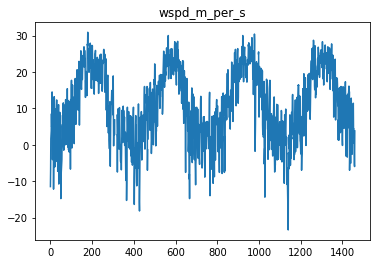

1


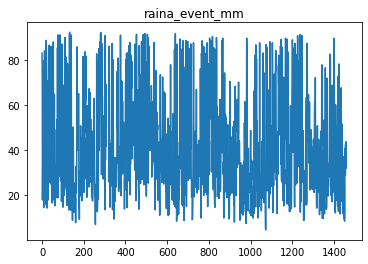

2


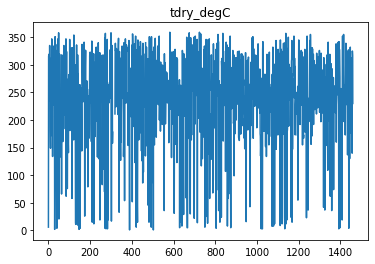

3


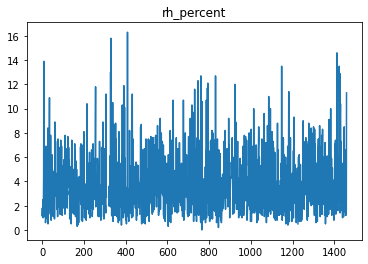

4


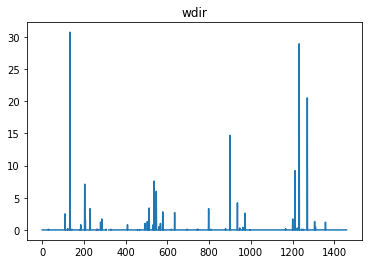

In [ ]:
#quickplot = 'yes'
#if quickplot == 'yes':
  ## Quick plots of your data
print(np.shape(data_2)[1])
print(data_2.shape)
for i in np.arange(0,np.shape(data_2)[1]):
    print(i)
    plt.plot(data_2[:,i]);
    plt.title(included_cols[i])
    plt.show()

**APPLY SCIENTIFIC METHOD**

In [ ]:
seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4}

def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k]

selectdf_3['season']=[season(month) for month in pd.DatetimeIndex(selectdf_3['day']).month]
(selectdf_3.head)
#plt.plot(df_3['season'])
#plt.show()

<bound method NDFrame.head of               day  hour_UTC Month Day     pres_mb  tdry_degC  rh_percent  \
4      2018-01-01       4.0    01  01  816.099976      -11.5   83.000000   
28     2018-01-02       4.0    01  02  813.400024       -6.8   74.300003   
52     2018-01-03       4.0    01  03  816.700012        1.6   17.700001   
76     2018-01-04       4.0    01  04  812.500000        2.7   31.799999   
100    2018-01-05       4.0    01  05  813.599976        3.8   29.000000   
...           ...       ...   ...  ..         ...        ...         ...   
34924  2021-12-27       4.0    12  27  799.299988        0.5   42.500000   
34948  2021-12-28       4.0    12  28  790.700012        0.9   37.099998   
34972  2021-12-29       4.0    12  29  795.000000       -5.5   37.200001   
34996  2021-12-30       4.0    12  30  798.400024       -6.0   43.599998   
35020  2021-12-31       4.0    12  31  792.000000        3.8   32.000000   

        wdir  wspd_m_per_s  wspdmax_m_per_s  raina_event_

**Scale Data to Get Unit Variance**


In [ ]:
included_cols = ['wspd_m_per_s','raina_event_mm','tdry_degC','rh_percent','wdir'] 

## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
data_2 = selectdf_3.loc[:, selectdf_3.columns.isin(list(included_cols))].to_numpy()


data_nomissing=data_2.copy();
print(data_nomissing.shape)

data_nomissing[:,0]=np.where(np.isnan(data_2[:,0])==True,np.nanmean(data_2[:,0]),data_2[:,0])
data_nomissing[:,1]=np.where(np.isnan(data_2[:,1])==True,np.nanmean(data_2[:,1]),data_2[:,1])
data_nomissing[:,2]=np.where(np.isnan(data_2[:,2])==True,np.nanmean(data_2[:,2]),data_2[:,2])
data_nomissing[:,3]=np.where(np.isnan(data_2[:,3])==True,np.nanmean(data_2[:,3]),data_2[:,3])
data_nomissing[:,4]=np.where(np.isnan(data_2[:,4])==True,np.nanmean(data_2[:,4]),data_2[:,4])


(1460, 5)


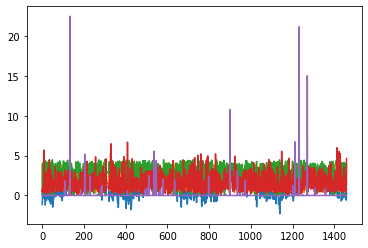

In [ ]:
scaled_data_2 = whiten(data_nomissing) 

#print('mean of each variable')
#print(np.mean(scaled_data,axis=0))
#print('standard deviation of each variable')
#print(np.std(scaled_data,axis=0))
plt.plot(scaled_data_2)

**Set Up Clustering**

In [ ]:
## select the number of clusters (i.e., here the number of seasons you want to try to identify using the weather data)
NO_CLUSTERS = 4 # use 4 clusters - see if you get out 4 seasons of winter, fall, spring, summer

## do the clustering, return centroids (i.e., Coordinates of cluster centers.)
## https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html
centroids, _  = kmeans(scaled_data_2,NO_CLUSTERS,iter=20)

In [ ]:
idx_2, _ = vq(scaled_data_2,centroids) # vq returns cluster idx for each observation

## add 1 so that idx is also 1-based like df['season']
idx_2=idx+1

print('Here is the cluster idx for each day of the year:') 
print(idx_2.shape) # prints K-mean's season label for each day

Here is the cluster idx for each day of the year:
(1461,)


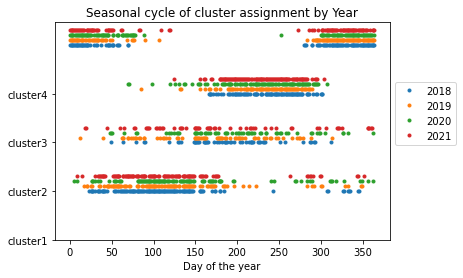

In [ ]:
### Make a quick plot to show the index results

### plot each year
plt.plot(idx_2[0:365],'.',label='2018');
plt.plot(idx_2[365:365*2]+0.1,'.',label='2019');
plt.plot(idx_2[365*2:365*3]+0.2,'.',label='2020');
plt.plot(idx_2[365*3:365*4]+0.3,'.',label='2021');

#plt.legend(loc='best');
plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left', ncol=1);
plt.yticks(np.arange(1,NO_CLUSTERS+1),labels=['cluster1','cluster2','cluster3','cluster4']);
plt.xlabel('Day of the year')
plt.title('Seasonal cycle of cluster assignment by Year');

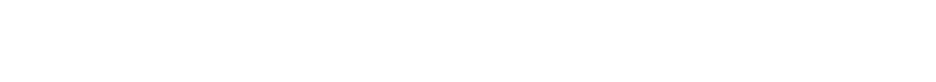

The code is the same as above, just without the rain variable and less number of clusters.

COLORADO W/3 CLUSTERS NO RAIN

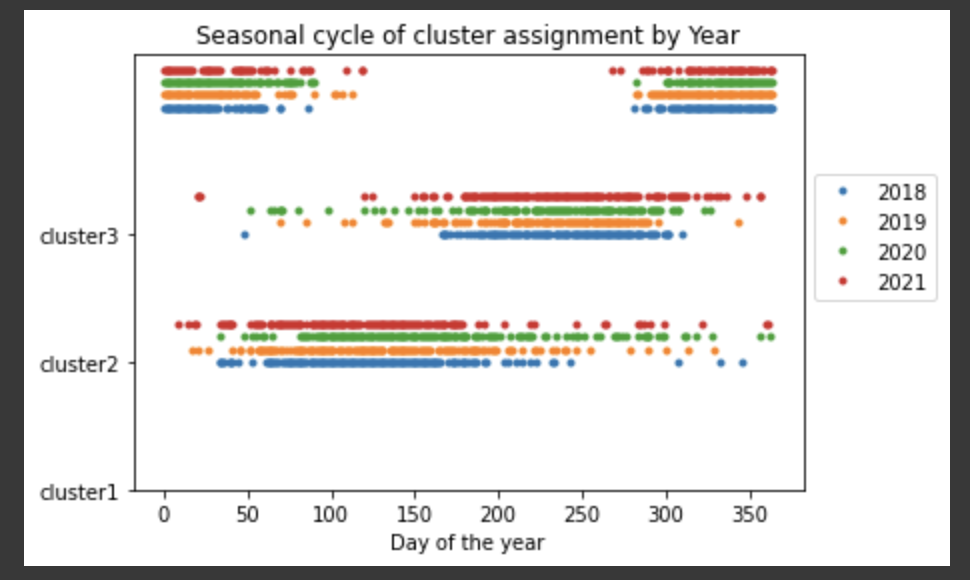

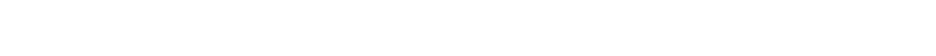

COLORADO W/2 CLUSTERS NO RAIN

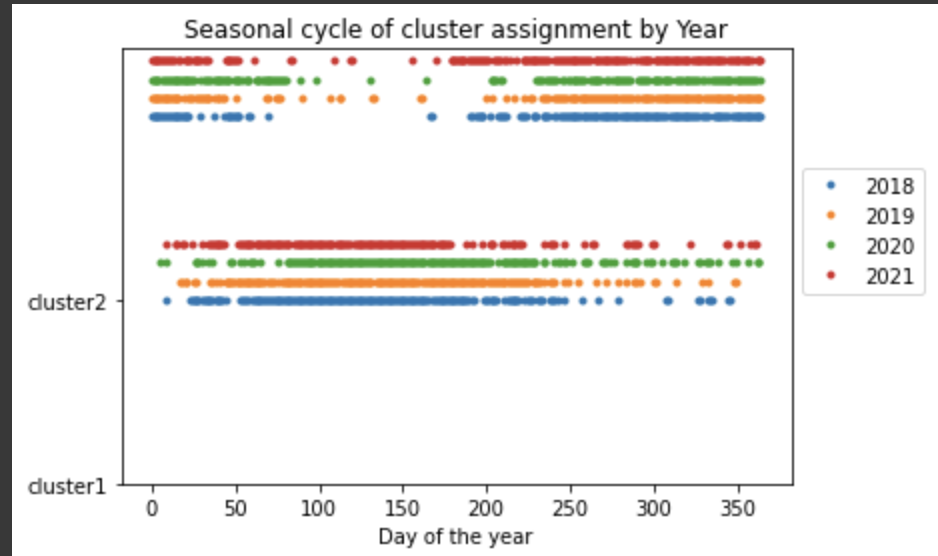

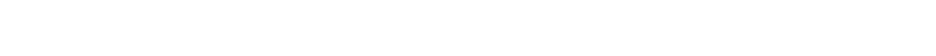

**Make 5 Plots with Mean Air Temperature C and Other Variables**

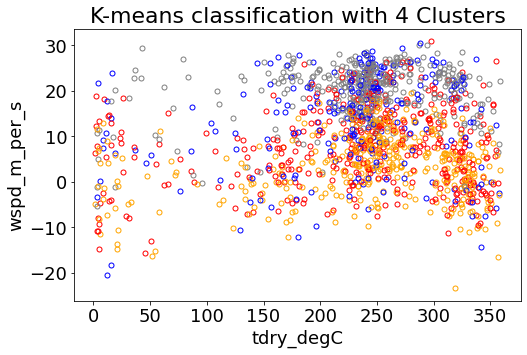

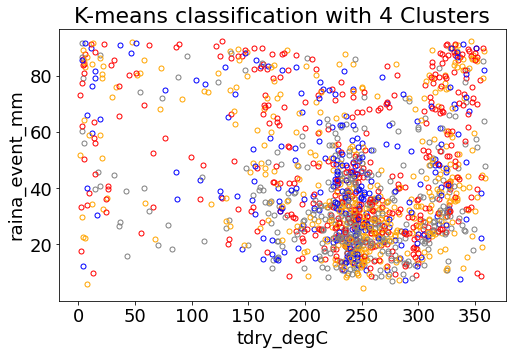

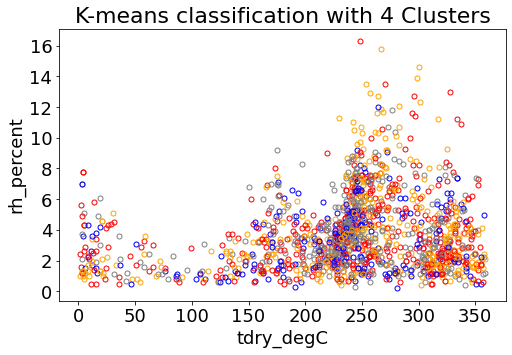

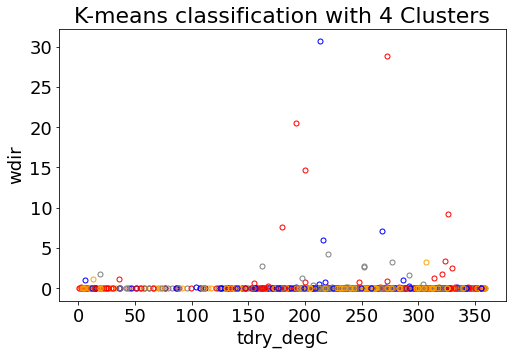

In [ ]:
## Create a few xy scatter plots, where points are colored by "season" (from clustering algorithm).

### Pick any two variables that are a part of included_cols
### [''wspd_m_per_s','raina_event_mm','tdry_degC','rh_percent','wdir'] '] 
##print(included_cols)

##### PLOT #5

### select two variables and put them in vars5plot - # format (x, y)
vars5plot = ['tdry_degC','wspd_m_per_s']
#print(f'plotting these variables: {vars5plot}')

data5plot = [data_2[:,included_cols.index(var)] for var in vars5plot]

## find the integer index of the variable to plot
varidx5plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  #print(vars5plot[i])
  varidx5plot[i]=included_cols.index(vars5plot[i])
#print(varidx5plot)

### Next plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data5plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars5plot[0],fontsize=18);
plt.ylabel(vars5plot[1],fontsize=18);
plt.show()

#plt.show()

##### PLOT #6

### select two variables and put them in vars6plot - # format (x, y)
vars6plot = ['tdry_degC','raina_event_mm'] 
#print(f'plotting these variables: {vars6plot}')

data6plot = [data_2[:,included_cols.index(var)] for var in vars6plot]

## find the integer index of the variable to plot
varidx6plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  varidx6plot[i]=included_cols.index(vars6plot[i])

### Now plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data6plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars6plot[0],fontsize=18);
plt.ylabel(vars6plot[1],fontsize=18);


##### PLOT #7

### select two variables and put them in vars7plot - # format (x, y)
vars7plot = ['tdry_degC','rh_percent'] 
#print(f'plotting these variables: {vars7plot}')

data7plot = [data_2[:,included_cols.index(var)] for var in vars7plot]

## find the integer index of the variable to plot
varidx7plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  varidx7plot[i]=included_cols.index(vars7plot[i])

### Now plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data7plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars7plot[0],fontsize=18);
plt.ylabel(vars7plot[1],fontsize=18);

##### PLOT #8

### select two variables and put them in vars8plot - # format (x, y)
vars8plot = ['tdry_degC','wdir']
#print(f'plotting these variables: {vars8plot}')

data8plot = [data_2[:,included_cols.index(var)] for var in vars8plot]

## find the integer index of the variable to plot
varidx8plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  varidx8plot[i]=included_cols.index(vars8plot[i])

### Now plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data8plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars8plot[0],fontsize=18);
plt.ylabel(vars8plot[1],fontsize=18);

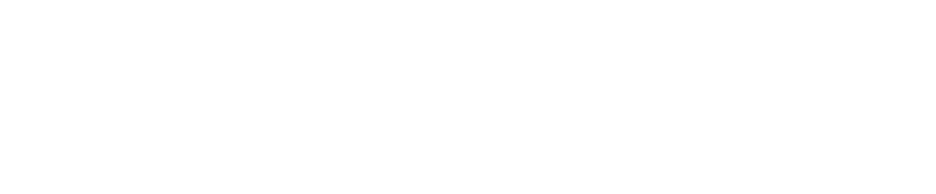

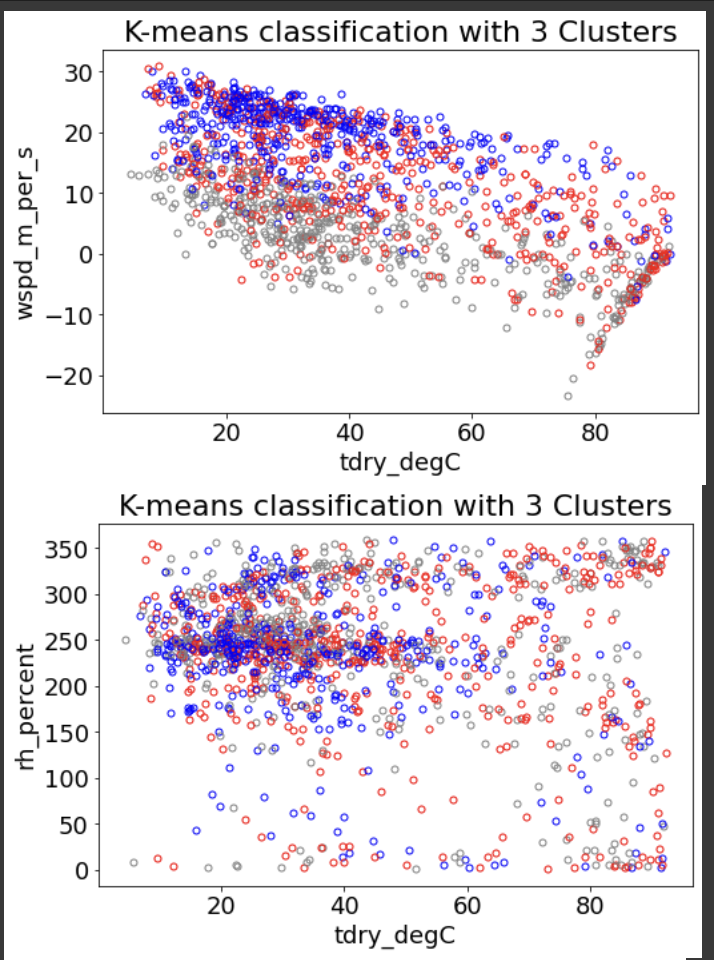

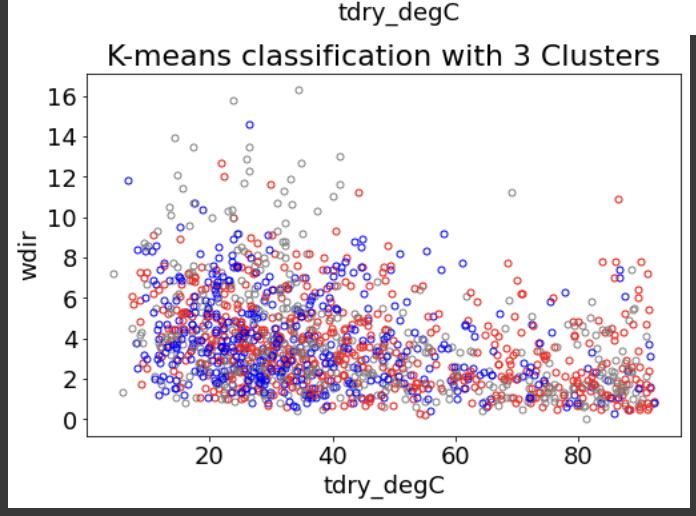

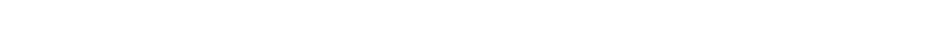

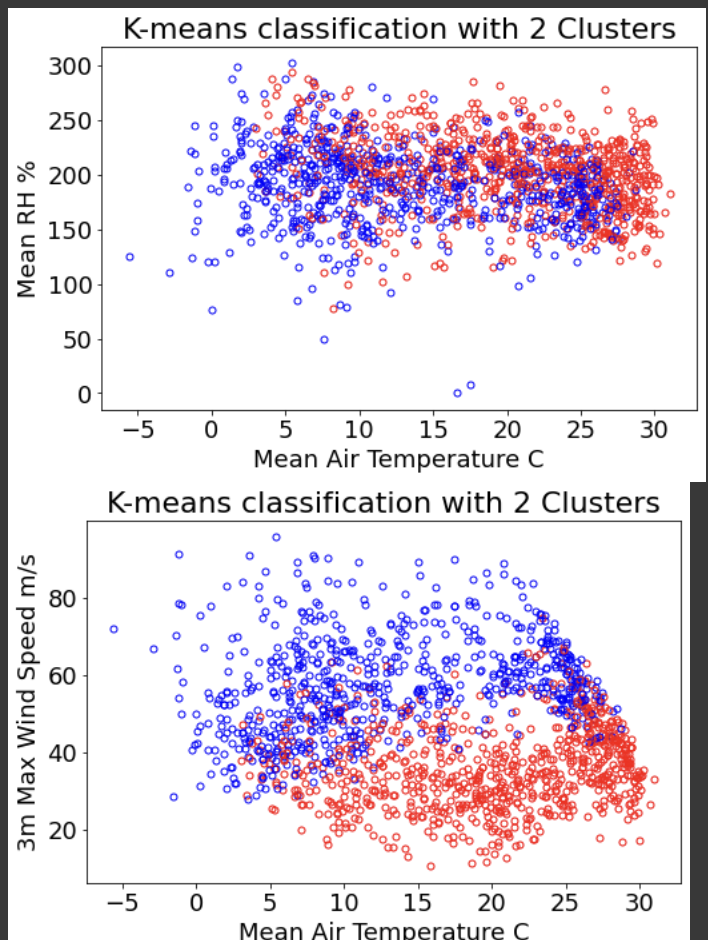

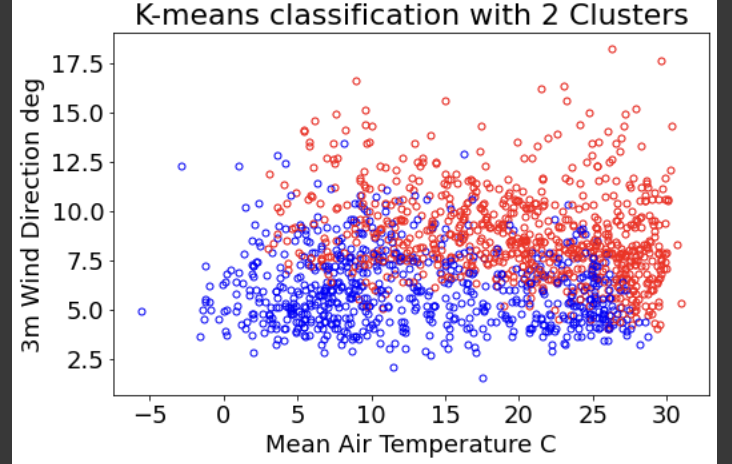

Two clusters works very well for Colorado. Each variable had clear, well defined clusters except relative humidity. 

**Prepare Histogram for Final Analysis**

In [ ]:
#### prepare data to plot in the histogram #2

## this is the actual season from the definition in the season dictionary above
season_idx_2=selectdf_3['season'][selectdf_3.hour_UTC==4].to_numpy()
print(season_idx_2.shape)

## this is the season from the k-means clustering algorithm
print(idx_2.shape)

### find what the k-means clustering assigned in each season

## find all of the days in winter, i.e., where season_idx=1
winteridx_2=np.nonzero(np.where(season_idx_2==1,1,0))
#print(winteridx) ### uncomment me to check the code
## find what values the k-means classified for this season
winter=idx_2[winteridx_2]
#print(winter)  ### uncomment me to check the code

## find all of the days in spring, i.e., where season_idx=2
springidx_2=np.nonzero(np.where(season_idx_2==2,1,0))
## find what values the k-means classified for this season
spring=idx_2[springidx_2]

## find all of the days in summer, i.e., where season_idx=3
summeridx_2=np.nonzero(np.where(season_idx_2==3,1,0))
## find what values the k-means classified for this season
summer=idx_2[summeridx_2]

## find all of the days in fall, i.e., where season_idx=4
fallidx_2=np.nonzero(np.where(season_idx_2==4,1,0))
## find what values the k-means classified for this season
fall=idx_2[fallidx_2]

(1460,)
(1461,)


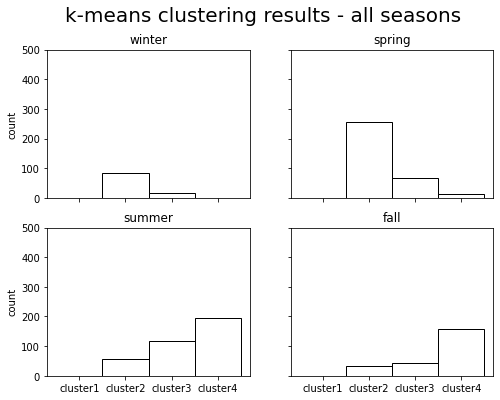

In [ ]:
### Histogram #2 - Histograms of seasons based on k-means clustering for each season

## define bins for the histogram
delta= 1                               ## bin size
minbin= 0.5                             ## minimum bin value
maxbin= 5.5                              ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
#print(hist_bins) ## print your histograms to check them

## sanity check = plot the histogram of assigned clusters for winter
#h, mids = np.histogram(winter,bins=hist_bins);
#labels4xaxis=['cluster1','cluster2','cluster3','cluster4']
#plt.figure(figsize=(4,4))
#plt.hist(winter,bins=mids,facecolor='w',edgecolor="k");
#plt.xticks(np.arange(1,4+1),labels=labels4xaxis);
#plt.title('Winter');
#plt.show();

### Show all seasons using subplots
### Help with subplots: https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

labels4xaxis=['','cluster1','cluster2','cluster3','cluster4']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('k-means clustering results - all seasons',fontsize=20)
fig.set_figheight(6)
fig.set_figwidth(8)

ymax=500
h, mids = np.histogram(winter,bins=hist_bins);
ax1.hist(winter,bins=mids,facecolor='w',edgecolor="k");
ax1.set_title("winter");
ax1.set_ylabel("count");
ax1.set_ylim(0,ymax)
h, mids = np.histogram(spring,bins=hist_bins);
ax2.hist(spring,bins=mids,facecolor='w',edgecolor="k");
ax2.set_title("spring");
ax2.set_ylim(0,ymax)
h, mids = np.histogram(summer,bins=hist_bins);
ax3.hist(summer,bins=mids,facecolor='w',edgecolor="k");
ax3.set_title("summer");
ax3.set_xticklabels(labels4xaxis);
ax3.set_ylabel("count");
ax3.set_ylim(0,ymax)
h, mids = np.histogram(fall,bins=hist_bins);
ax4.hist(fall,bins=mids,facecolor='w',edgecolor="k");
ax4.set_title("fall");
ax4.set_xticklabels(labels4xaxis);
ax4.set_ylim(0,ymax)

for ax in fig.get_axes():
    ax.label_outer()

The code is the same as above, just without the rain variable and less number of clusters.

COLORADO W/3 CLUSTERS NO RAIN 

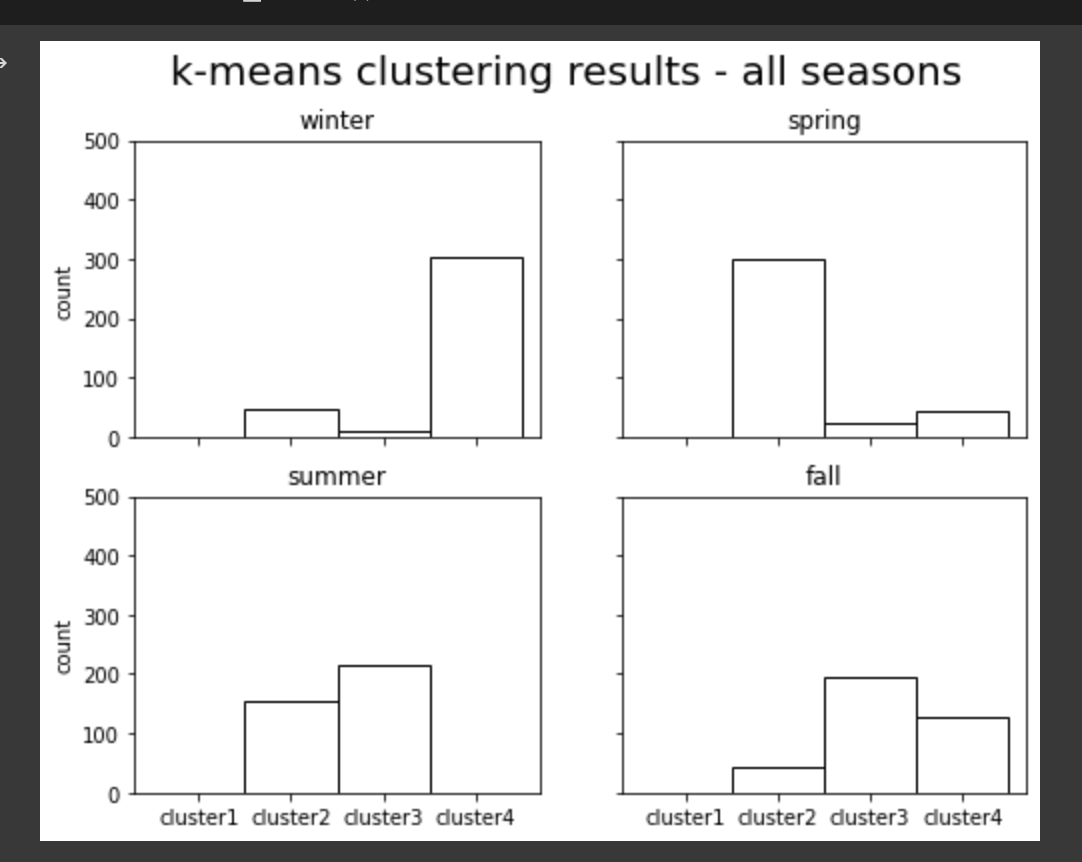

COLORADO W/2 CLUSTERS NO RAIN 

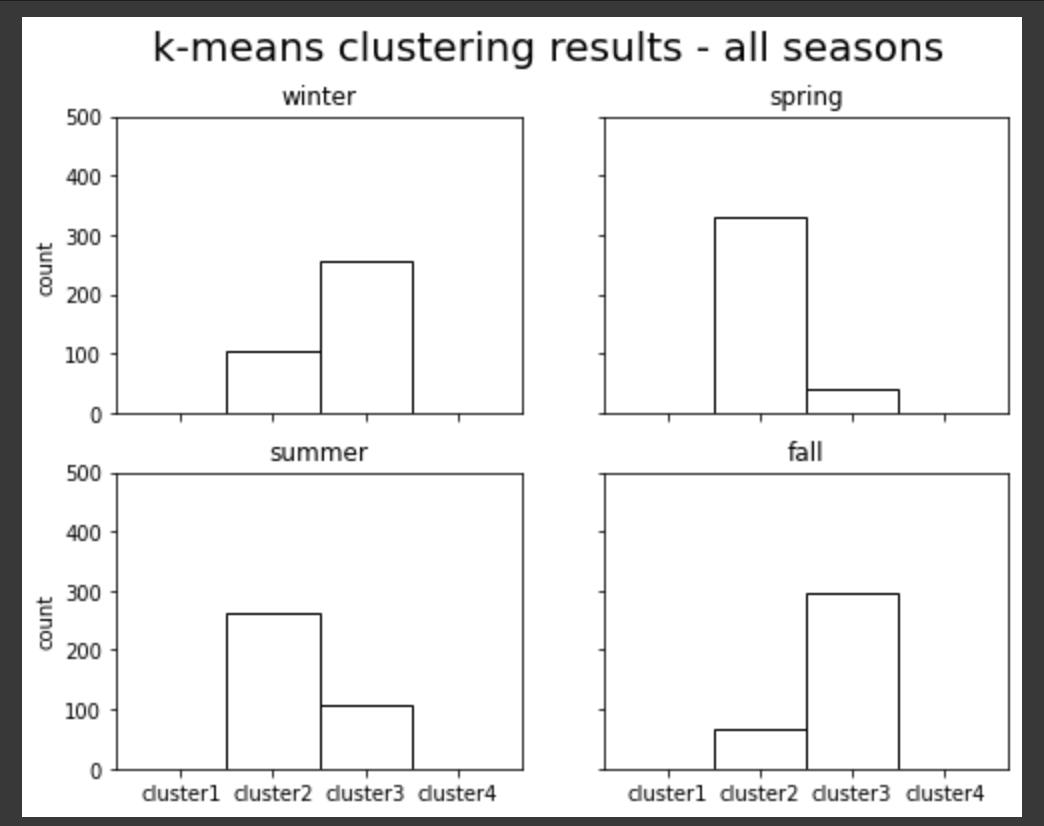

**CONCLUSION/SUMMARY**

Through this notebook I was testing the seasonal variability between two separate climates, La Mesa, New Mexico and Boulder, Colorado. I predicted that temperature and snow were going to be the most influential variables in this clustering analysis. After finishing the analysis, I can conclude that 3 clusters worked the best with the southern New Mexico climate. The plots were well defined and clean and clearly stated that fall was a transition period.  This was not the case for Colorado's climate. When I looked at the individual variable plots, they were all over the place with no indication of a pattern. Although 2 clusters working best for colorado, I can conclude that Colorado has more seasonal variability than southern New Mexico but more data is needed to determine the amount of seasons that work best in Colorado's climate. In a future analysis, I would remove relative humidity as those graphs are all over the place and no amount of clustering improved them.

EDITS MADE:


1.   From Giovanni's suggestions, I removed the extra graphs of the scaled data from both datasets. The graphs showed the scaled data with less clusters, but because no clustering was done yet, these extra graphs were not necessary and showed the same thing. 
2.   Jackie's and Jacob's suggestion was to include a conclusion/key takeaways for each graph to make it more clear and to help keep the viewer on track to the end results. 
3.   Gillian's suggestion was to omit certain cells that were necessary to keep for the execution of the notebook. She said there were cells that were might've been helpful for the creator to use in making the notebook, but now they can be removed. This helps with the length of the notebook to seem less overwhelming.